In [15]:
# Load the minimum required library to run the functions
from Utils_functions import get_theta_from_prior
from numpy.random import uniform
from numpy import array, int64, where, concatenate, linspace, median, sum, log, zeros, mean, var, min, max, einsum
from scipy.integrate import cumulative_trapezoid
from scipy.signal import welch
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm import tqdm
import seaborn as sns
import _pickle as pickle
from InternalLibrary.StatisticalFunctions import *
from torch import Tensor, Size
from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from numpy import squeeze
from InternalLibrary.SimulatorPackage import Simulator_noGPU

In [16]:
dt = 1e-6# The time step size for the simulation. This is the amount of time that passes in the model for each step of the simulation
Sample_frequency = 25_000 # The sampling frequency. This is the number of samples that are recorded per unit time
DeltaT = 1/Sample_frequency # The sampling period. This is the amount of time that passes in the model between each sample that is recorded
TotalT = 0.5 # The total time for the simulation. This is the total amount of time that the simulation is intended to represent
n_sim = int(10)
t_corr = TotalT/50

In [17]:
# Limits for the parameters (kbT=3.8 pN nm)
prior_limits = [[1e4, 140e4],     # mu_y [0] 
                [1.5e-2, 30e-2],  # k_y [1]
                [1e-3, 6e-3],     # k_int [2]
                [2e-2, 20e-2],    # tau [3]
                [0.5, 6]]       # eps [4]]         # D_y (depending on T and mu_y)

In [18]:
first = True
n = 0
for stat in statistics_from_file(max_files_to_analyze=80):
    print(f"Loading file {n}\r",end="")
    for i in range(len(stat)):
        s = select_summary_statistics(stat[i], ["Cxx", "s_redx", "psdx", "hermite"])
        theta = stat[i]["theta"]
        theta = torch.from_numpy(theta).to(torch.float32)
        if first:
            s_tot = s
            theta_tot = theta.T
            first = False
        else:
            s_tot = torch.cat((s_tot, s), dim=0)
            theta_tot = torch.cat((theta_tot, theta.T), dim=0)
    n += 1
s_tot = s_tot.to(torch.float32)

In [19]:
prior_limits_array = array(prior_limits)
prior_box = utils.torchutils.BoxUniform(low=torch.tensor(prior_limits_array[:, 0]), high=torch.tensor(prior_limits_array[:, 1]))

In [20]:
# Prior distribution for sbi
prior, num_parameters, prior_returns_numpy = process_prior(prior_box)

In [21]:
theta_tot.shape

torch.Size([2000, 5])

In [22]:
# Call infer form sbi
infer = SNPE(prior=prior)
inferece = infer.append_simulations(theta_tot, s_tot)

In [23]:
# Train the model
density_estimator = infer.train()
posterior = infer.build_posterior(density_estimator)

 Neural network successfully converged after 32 epochs.

In [25]:
samples = posterior.sample((int(1e5),), x=s_tot[0])

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

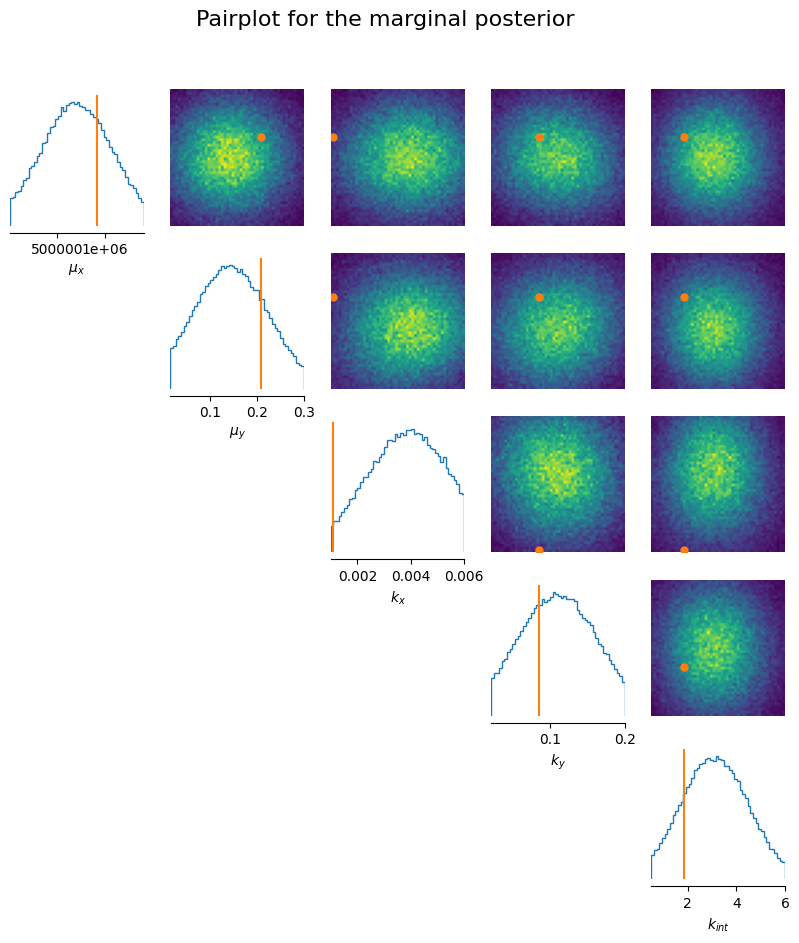

In [26]:
# Pairplot
label_theta = [r"$\mu_y$", r"$k_y$", r"k_{int}$", r"$\tau$", r"$\varepsilon$"]
import matplotlib as mpl
_ = analysis.pairplot(samples, points=[theta_tot[0]], 
                      limits=prior_limits, figsize=(10, 10), 
                      title = "Pairplot for the marginal posterior",
                      labels=label_theta)